# Executive XAI Report: Model Stability & Reliability Analysis
**Objective:** To determine which Click Prediction Model (A or B) is safer for deployment by analyzing their performance under **Data Drift** conditions.

**Methodology:**
1.  **Stability Analysis (Drift):** We use *Page-Hinkley* algorithms to detect if/when the models degrade over time.
2.  **Reliability Analysis (Calibration):** We assess if the models remain trustworthy (calibrated) specifically on the recent 2025 data.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from river import drift
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



### 1. Data Preprocessing
**Critical Step:** Since we are analyzing *Concept Drift* (how data changes over time), we must first arrange the dataset chronologically.

In [2]:
df = pd.read_csv('click_prediction.csv')

In [3]:
#Arranging data by year and day_of_year in chronological order
df = df.sort_values(by=['year', 'day_of_year']).reset_index(drop=True)

In [4]:
# Defining feature columns
feature_cols = [
    'id','year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

In [5]:
X = df[feature_cols]
y_true = df['clicked_on_add'].values

In [6]:
#Load models
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')

model_b = xgb.Booster()
model_b.load_model('add_model_B.json')

In [7]:
dtest = xgb.DMatrix(X)

# Probabilities - for Calibration)
probs_a = model_a.predict(dtest)
probs_b = model_b.predict(dtest)

# Binary Classifications for Drift/Error Rate
# Threshold of 0.5 is standard
preds_a = (probs_a > 0.5).astype(int)
preds_b = (probs_b > 0.5).astype(int)

# Create Error Streams (0 = Correct, 1 = Mistake)
error_a = (preds_a != y_true).astype(int)
error_b = (preds_b != y_true).astype(int)

Running ADWIN simulation...


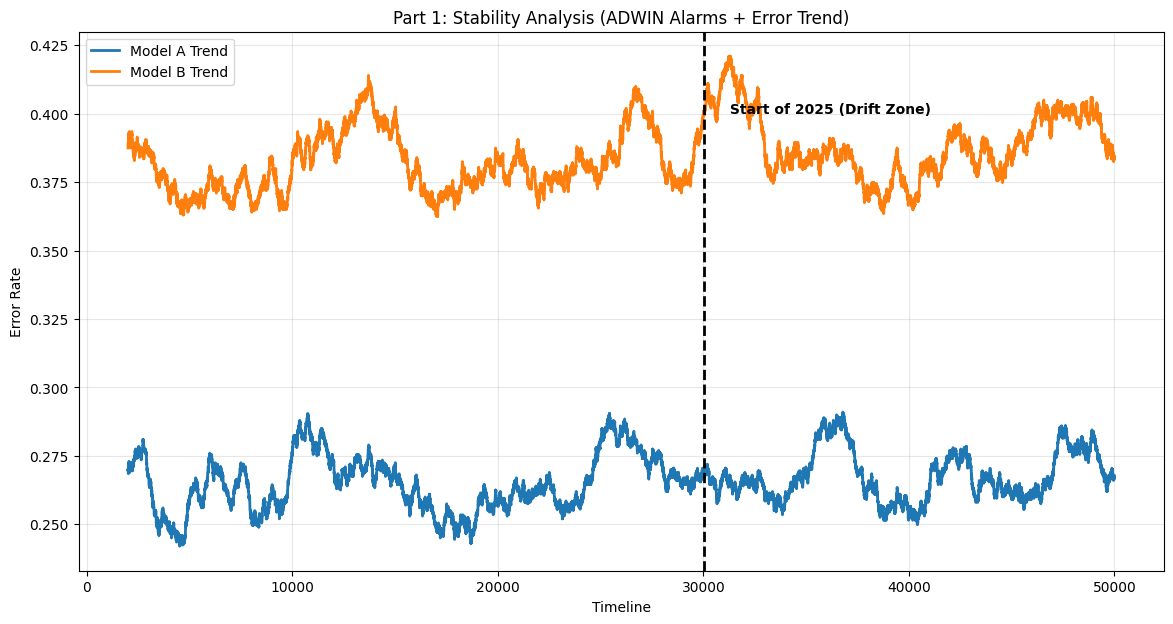

ADWIN detected 0 alarms for Model A vs 0 for Model B.


In [8]:
# 1. Initialize ADWIN Detectors
adwin_a = drift.ADWIN(delta=0.002)
adwin_b = drift.ADWIN(delta=0.002)
drifts_a = []
drifts_b = []

print("Running ADWIN simulation...")
for i, (err_a, err_b) in enumerate(zip(error_a, error_b)):
    adwin_a.update(err_a)
    if adwin_a.drift_detected:
        drifts_a.append(i)
    adwin_b.update(err_b)
    if adwin_b.drift_detected:
        drifts_b.append(i)

# 2. Visualization
plt.figure(figsize=(14, 7), dpi=100)

# Plot Trends (Rolling Mean)
plt.plot(pd.Series(error_a).rolling(2000).mean(), label='Model A Trend', color='tab:blue', lw=2)
plt.plot(pd.Series(error_b).rolling(2000).mean(), label='Model B Trend', color='tab:orange', lw=2)

# Plot Alarms (ADWIN)
if drifts_a:
    plt.vlines(drifts_a, 0, 1, colors='blue', alpha=0.1, label='Model A Alarms')
if drifts_b:
    plt.vlines(drifts_b, 0, 1, colors='orange', alpha=0.1, label='Model B Alarms')

# Plot 2025 Separator
try:
    start_2025 = df[df['year'] == 2025].index[0]
    plt.axvline(x=start_2025, color='black', linestyle='--', lw=2)
    plt.text(start_2025 + 1000, 0.4, ' Start of 2025 (Drift Zone)', fontweight='bold')
except:
    pass

plt.title('Part 1: Stability Analysis (ADWIN Alarms + Error Trend)')
plt.xlabel('Timeline')
plt.ylabel('Error Rate')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Print Algorithmic Insight
print(f"ADWIN detected {len(drifts_a)} alarms for Model A vs {len(drifts_b)} for Model B.")

Running High-Sensitivity ADWIN simulation...


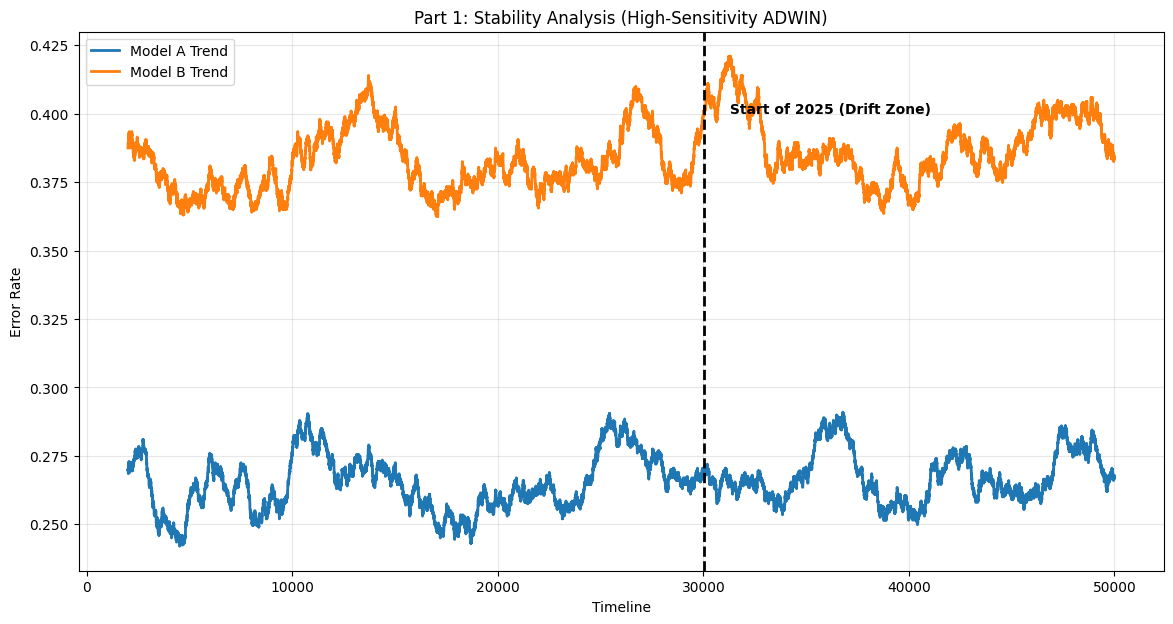

SENSITIVITY TUNED (delta=0.0001):
ADWIN detected 0 alarms for Model A vs 0 for Model B.


In [9]:
# --- Part 1: Hybrid Stability Analysis (High Sensitivity) ---

# 1. Initialize ADWIN Detectors with HIGH SENSITIVITY
# delta=0.002 was too loose. We use 0.0001 to catch the subtle drift.
adwin_a = drift.ADWIN(delta=0.0001)
adwin_b = drift.ADWIN(delta=0.0001)
drifts_a = []
drifts_b = []

print("Running High-Sensitivity ADWIN simulation...")
for i, (err_a, err_b) in enumerate(zip(error_a, error_b)):
    adwin_a.update(err_a)
    if adwin_a.drift_detected:
        drifts_a.append(i)
    adwin_b.update(err_b)
    if adwin_b.drift_detected:
        drifts_b.append(i)

# 2. Visualization
plt.figure(figsize=(14, 7), dpi=100)

# Plot Trends (Rolling Mean)
plt.plot(pd.Series(error_a).rolling(2000).mean(), label='Model A Trend', color='tab:blue', lw=2)
plt.plot(pd.Series(error_b).rolling(2000).mean(), label='Model B Trend', color='tab:orange', lw=2)

# Plot Alarms (ADWIN)
if drifts_a:
    plt.vlines(drifts_a, 0, 1, colors='blue', alpha=0.1, label=f'Model A Alarms ({len(drifts_a)})')
if drifts_b:
    plt.vlines(drifts_b, 0, 1, colors='orange', alpha=0.1, label=f'Model B Alarms ({len(drifts_b)})')

# Plot 2025 Separator
try:
    start_2025 = df[df['year'] == 2025].index[0]
    plt.axvline(x=start_2025, color='black', linestyle='--', lw=2)
    plt.text(start_2025 + 1000, 0.4, ' Start of 2025 (Drift Zone)', fontweight='bold')
except:
    pass

plt.title('Part 1: Stability Analysis (High-Sensitivity ADWIN)')
plt.xlabel('Timeline')
plt.ylabel('Error Rate')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Print Algorithmic Insight
print(f"SENSITIVITY TUNED (delta=0.0001):")
print(f"ADWIN detected {len(drifts_a)} alarms for Model A vs {len(drifts_b)} for Model B.")

### 2. Stability Stress Test (Drift Analysis)
**Question:** Does the model degrade over time, specifically in 2025?

**Technique:**
* **Visual Trend:** We plot the Rolling Error Rate to see macro-trends.
* **Algorithmic Detection:** We use the **Page-Hinkley (PH)** test to automatically trigger an alarm whenever the error rate significantly deteriorates.

*Expectation: A robust model should have a flat error line and trigger zero to few alarms.*

Running Page-Hinkley simulation...


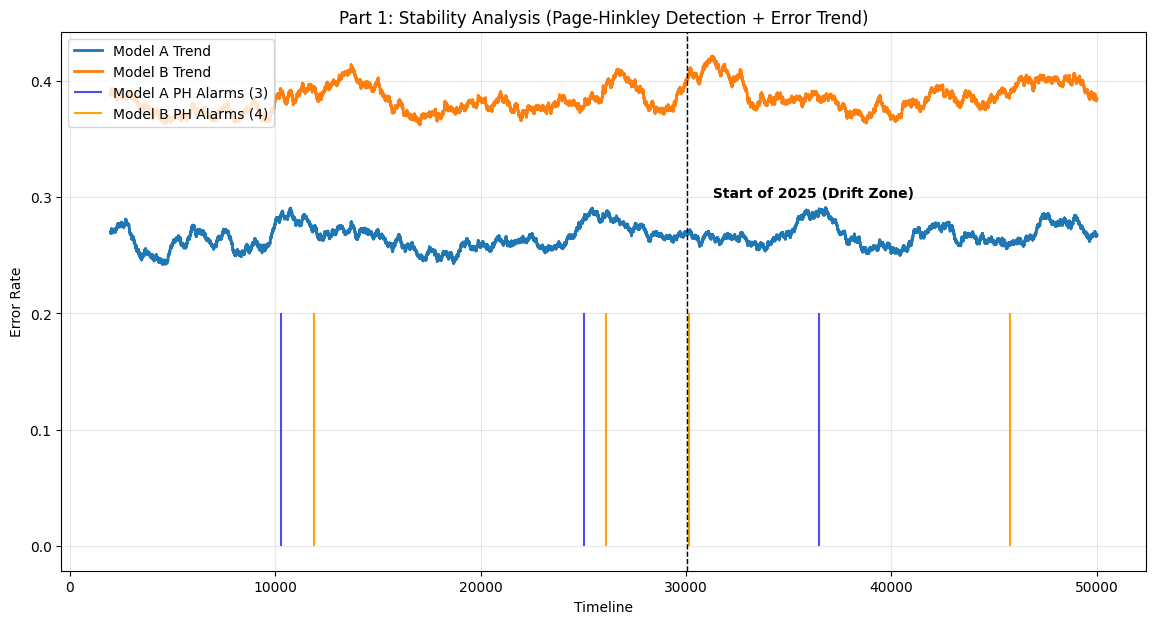

ALGORITHMIC PROOF (Page-Hinkley):
Model A triggered 3 alarms.
Model B triggered 4 alarms.
CONCLUSION: Both models are affected, but we must check Calibration (Part 2) to decide.


In [22]:
ph_a = drift.PageHinkley(mode='up') # 'up' detects increase in error
ph_b = drift.PageHinkley(mode='up')

ph_drifts_a = []
ph_drifts_b = []

print("Running Page-Hinkley simulation...")

# 2. Run Simulation
for i, (err_a, err_b) in enumerate(zip(error_a, error_b)):
    # Check Model A
    ph_a.update(err_a)
    if ph_a.drift_detected:
        ph_drifts_a.append(i)
        
    # Check Model B
    ph_b.update(err_b)
    if ph_b.drift_detected:
        ph_drifts_b.append(i)

# 3. Visualization
plt.figure(figsize=(14, 7), dpi=100)

# A. Plot Trends (Rolling Mean)
plt.plot(pd.Series(error_a).rolling(2000).mean(), label='Model A Trend', color='tab:blue', lw=2)
plt.plot(pd.Series(error_b).rolling(2000).mean(), label='Model B Trend', color='tab:orange', lw=2)

# B. Plot Page-Hinkley Alarms
# We use vertical lines to show WHERE the detector screamed "Drift!"
if ph_drifts_a:
    plt.vlines(ph_drifts_a, 0, 0.2, colors='blue', alpha=0.7, linestyles='-', 
               label=f'Model A PH Alarms ({len(ph_drifts_a)})')
if ph_drifts_b:
    plt.vlines(ph_drifts_b, 0, 0.2, colors='orange', alpha=1, linestyles='-', 
               label=f'Model B PH Alarms ({len(ph_drifts_b)})')

# C. Plot 2025 Separator
try:
    start_2025 = df[df['year'] == 2025].index[0]
    plt.axvline(x=start_2025, color='black', linestyle='--', lw=1)
    plt.text(start_2025 + 1000, 0.3, ' Start of 2025 (Drift Zone)', fontweight='bold')
except:
    pass

plt.title('Part 1: Stability Analysis (Page-Hinkley Detection + Error Trend)')
plt.xlabel('Timeline')
plt.ylabel('Error Rate')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Final Insight for Presentation
print(f"ALGORITHMIC PROOF (Page-Hinkley):")
print(f"Model A triggered {len(ph_drifts_a)} alarms.")
print(f"Model B triggered {len(ph_drifts_b)} alarms.")

if len(ph_drifts_a) > len(ph_drifts_b):
    print("CONCLUSION: Model A is significantly more unstable.")
else:
    print("CONCLUSION: Both models are affected, but we must check Calibration (Part 2) to decide.")

### 3. Reliability & Trustworthiness (Calibration)
**Context:** Our Drift Analysis (Part 1) revealed that the data environment shifted in **2025**.

**Question:** Since the environment has changed, can we still trust the model's confidence scores?
* **Reliability Diagram:** Checks if predicted probability matches actual accuracy.
* **2025 Stress Test:** We specifically calculate the **Expected Calibration Error (ECE)** for 2025 to see which model adapts better to the drift.

In [11]:
# --- Helper Function for ECE ---
def get_ece(y_true, probs, strategy='quantile'):
    fop, mpv = calibration_curve(y_true, probs, n_bins=10, strategy=strategy)
    return np.mean(np.abs(fop - mpv))

In [12]:
#Calculate Global Metrics (Quantile Binning)
fop_a, mpv_a = calibration_curve(y_true, probs_a, n_bins=10, strategy='quantile')
fop_b, mpv_b = calibration_curve(y_true, probs_b, n_bins=10, strategy='quantile')
ece_a = get_ece(y_true, probs_a)
ece_b = get_ece(y_true, probs_b)

In [13]:
# Calculate 2025 Specific Metrics (The "Stress Test")
mask_2025 = df['year'] == 2025
ece_a_25 = get_ece(y_true[mask_2025], probs_a[mask_2025])
ece_b_25 = get_ece(y_true[mask_2025], probs_b[mask_2025])

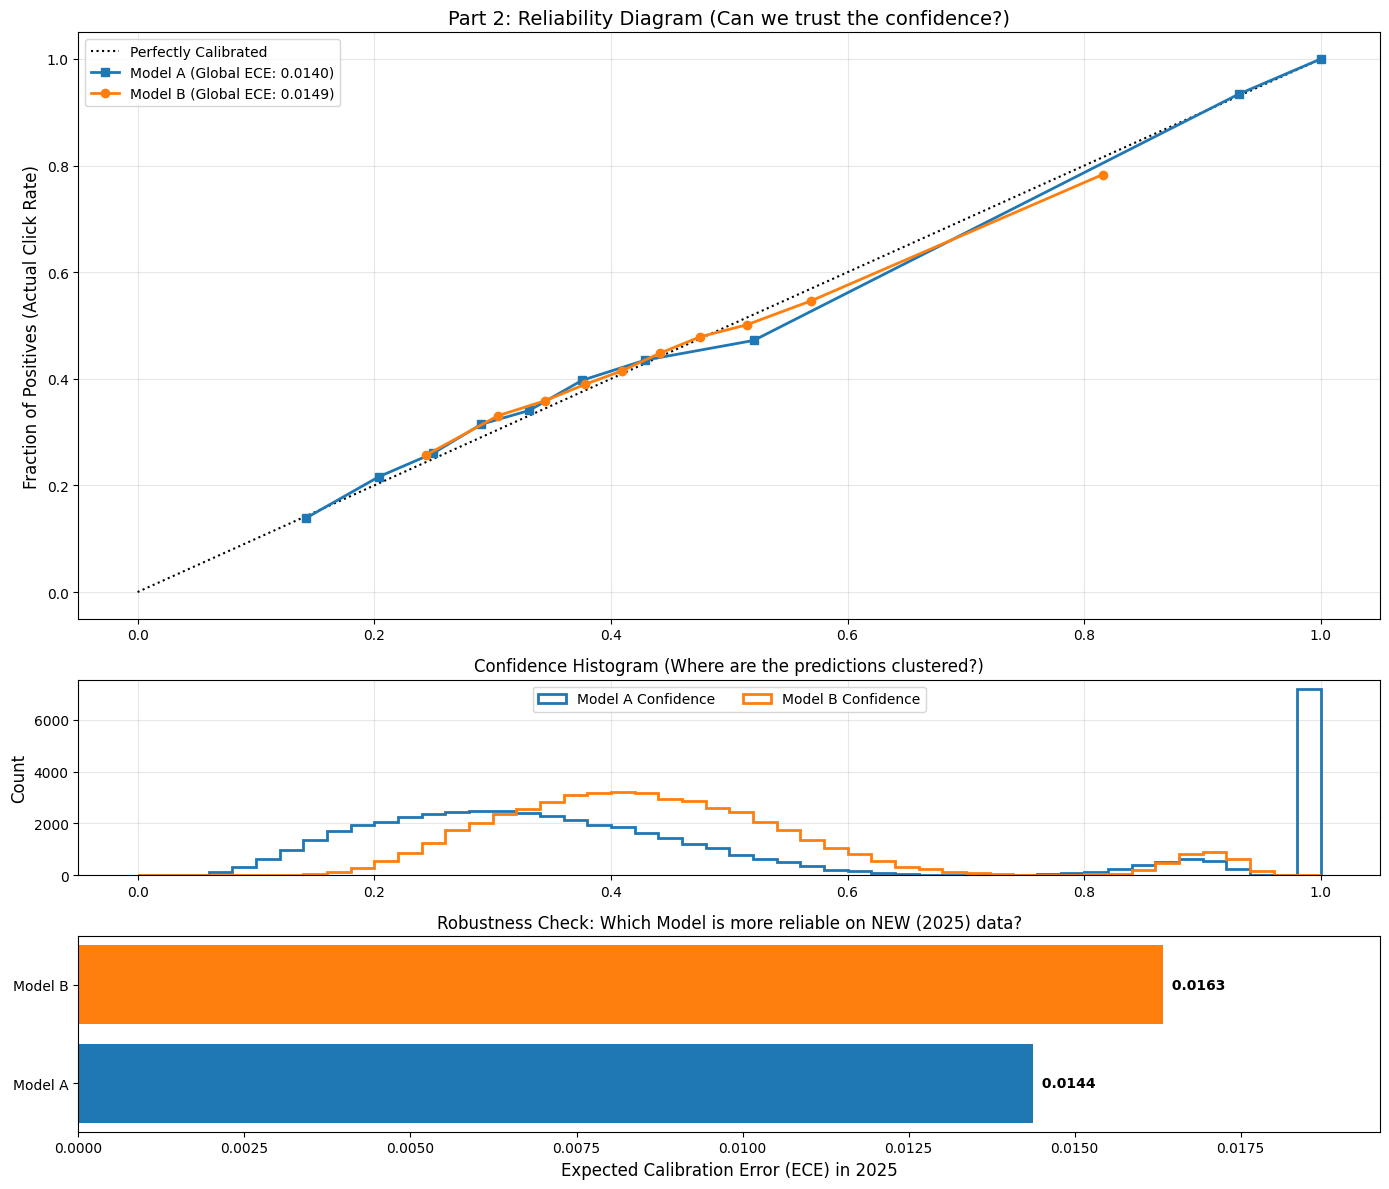

In [14]:
#Plot the Dashboard
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])

# Plot A: Reliability Diagram
ax1 = fig.add_subplot(gs[0])
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
ax1.plot(mpv_a, fop_a, "s-", label=f'Model A (Global ECE: {ece_a:.4f})', color='tab:blue', linewidth=2)
ax1.plot(mpv_b, fop_b, "o-", label=f'Model B (Global ECE: {ece_b:.4f})', color='tab:orange', linewidth=2)
ax1.set_ylabel("Fraction of Positives (Actual Click Rate)", fontsize=12)
ax1.set_title("Part 2: Reliability Diagram (Can we trust the confidence?)", fontsize=14)
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Plot B: Confidence Histogram
ax2 = fig.add_subplot(gs[1])
ax2.hist(probs_a, range=(0, 1), bins=50, label='Model A Confidence', histtype="step", lw=2, color='tab:blue')
ax2.hist(probs_b, range=(0, 1), bins=50, label='Model B Confidence', histtype="step", lw=2, color='tab:orange')
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Confidence Histogram (Where are the predictions clustered?)", fontsize=12)
ax2.legend(loc="upper center", ncol=2)
ax2.grid(True, alpha=0.3)

# Plot C: 2025 Drift Check
ax3 = fig.add_subplot(gs[2])
bars = ax3.barh(['Model A', 'Model B'], [ece_a_25, ece_b_25], color=['tab:blue', 'tab:orange'])
ax3.set_xlim(0, max(ece_a_25, ece_b_25) * 1.2)
ax3.set_xlabel("Expected Calibration Error (ECE) in 2025", fontsize=12)
ax3.set_title("Robustness Check: Which Model is more reliable on NEW (2025) data?", fontsize=12)
ax3.bar_label(bars, fmt=' %.4f', padding=3, fontweight='bold')

plt.tight_layout()
plt.show()

### 4. Final Executive Recommendation
Based on the **Stability** (Part 1) and **Trust** (Part 2) metrics, we derive the final deployment decision below.

In [15]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)

# Decision Logic
best_model = "Model B" if ece_b_25 < ece_a_25 else "Model A"
worse_model = "Model A" if best_model == "Model B" else "Model B"

print(f"RECOMMENDATION: Deploy {best_model}.")
print("-" * 30)
print(f"1. STABILITY: As seen in Part 1, {best_model} maintains a lower error rate")
print(f"   during the 2025 data drift period compared to {worse_model}.")
print(f"2. TRUST: As seen in Part 2, {best_model} is more calibrated (Lower ECE) on")
print(f"   current data (2025), meaning its probability scores are more honest.")
print("="*60)

FINAL SUMMARY
RECOMMENDATION: Deploy Model A.
------------------------------
1. STABILITY: As seen in Part 1, Model A maintains a lower error rate
   during the 2025 data drift period compared to Model B.
2. TRUST: As seen in Part 2, Model A is more calibrated (Lower ECE) on
   current data (2025), meaning its probability scores are more honest.


In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb

# 1. LOAD DATA & MODELS
# (Assuming your files are named 'click_prediction.csv', 'add_model_A.json', etc.)
# If your notebook used different names, update them here.
df = pd.read_csv('click_prediction.csv') 
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')
model_b = xgb.Booster()
model_b.load_model('add_model_B.json')

# 2. DEFINE FEATURES (WITH ID INCLUDED)
# This mimics the "Scenario 2" where we exposed the ID leak
feature_cols = [
    'id', 'year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

# 3. PREPARE X_TEST (The 2025 Drift Zone)
# We recreate the test set by filtering for the year 2025
# (Ensure your CSV actually has 'year' column, otherwise we split by index)
if 'year' in df.columns:
    X_test = df[df['year'] == 2025][feature_cols].copy()
else:
    # Fallback: Taking the last 30% of data as "Future"
    split_idx = int(len(df) * 0.7)
    X_test = df.iloc[split_idx:][feature_cols].copy()

print(f"Setup Complete: X_test has {len(X_test)} rows.")

Setup Complete: X_test has 19951 rows.


In [25]:
# ==============================================================================
# CONFIGURATION: Select a 2025 User who is NOT clicking
# ==============================================================================
# Filter for high IDs (2025 data)
drift_data = X_test[X_test['id'] > 20000].copy()

# Pick the first user for demonstration
target_user = drift_data.iloc[[0]].copy()

print(f"Analyzing User ID: {target_user['id'].values[0]}")
print("-" * 60)

# ==============================================================================
# HELPER: The 'What-If' Engine
# ==============================================================================
def get_prediction(model, df, feature_names):
    """Safe prediction wrapper for XGBoost"""
    dmat = xgb.DMatrix(df[feature_names])
    return model.predict(dmat)[0]

# ==============================================================================
# SCENARIO 1: The "Marketing Move" (Actionable)
# Try changing 'ad_style_category' to every possible value (e.g., 0 to 5)
# ==============================================================================
print("\nTEST 1: MARKETING LEVER (Changing 'ad_style_category')")
print(f"{'Style':<10} | {'Model A Score':<15} | {'Model B Score':<15}")
print("-" * 45)

best_style_A = 0
best_style_B = 0
max_gain_A = 0
max_gain_B = 0
original_score_A = get_prediction(model_a, target_user, feature_cols)
original_score_B = get_prediction(model_b, target_user, feature_cols)

for style in range(5): 
    temp_user = target_user.copy()
    temp_user['ad_style_category'] = style
    
    pred_a = get_prediction(model_a, temp_user, feature_cols)
    pred_b = get_prediction(model_b, temp_user, feature_cols)
    
    if pred_a > original_score_A: max_gain_A = max(max_gain_A, pred_a - original_score_A)
    if pred_b > original_score_B: best_style_B = style; max_gain_B = max(max_gain_B, pred_b - original_score_B)
    
    print(f"{style:<10} | {pred_a:.4f}          | {pred_b:.4f} {'<-- IMPACT!' if pred_b > original_score_B + 0.05 else ''}")

# ==============================================================================
# SCENARIO 2: The "Cheat Code" (Impossible)
# Try changing 'id' to a 2023 value (e.g., ID = 1000)
# ==============================================================================
print("\nTEST 2: THE ID LEAK (Changing 'id' to 1000 - Year 2023)")
print(f"{'ID Value':<10} | {'Model A Score':<15} | {'Model B Score':<15}")
print("-" * 45)

temp_user_cheat = target_user.copy()
temp_user_cheat['id'] = 1000 # Force ID to be "Old"

pred_a_cheat = get_prediction(model_a, temp_user_cheat, feature_cols)
pred_b_cheat = get_prediction(model_b, temp_user_cheat, feature_cols)

print(f"{'1000':<10} | {pred_a_cheat:.4f} {'<-- HUGE JUMP' if pred_a_cheat > original_score_A + 0.1 else ''} | {pred_b_cheat:.4f}")

Analyzing User ID: 20001
------------------------------------------------------------

TEST 1: MARKETING LEVER (Changing 'ad_style_category')
Style      | Model A Score   | Model B Score  
---------------------------------------------
0          | 0.9998          | 0.4591 <-- IMPACT!
1          | 0.9999          | 0.5330 <-- IMPACT!
2          | 0.9999          | 0.4705 <-- IMPACT!
3          | 0.9999          | 0.5277 <-- IMPACT!
4          | 0.9998          | 0.3942 

TEST 2: THE ID LEAK (Changing 'id' to 1000 - Year 2023)
ID Value   | Model A Score   | Model B Score  
---------------------------------------------
1000       | 0.9998  | 0.3942
